---
title: OSM - cityseer
date-format: long
date-modified: last-modified
lang: en
language:
  title-block-modified: "Last update"
---

See the accompanying discussion in the [guide](https://cityseer.benchmarkurbanism.com/guide).


Install and update `cityseer` if necessary.


In [1]:
# !pip install --upgrade cityseer
# !pip install osmnx

## Setup

If you're prepared to get your hands dirty, it is possible to directly query the [OSM API](https://wiki.openstreetmap.org/wiki/API) and to then use this data to create a `cityseer` graph. This can be preferred in situations where you want detailed control over the structure of the OSM API query. However, if you prefer, `OSM` data can also be retrieved with [`OSMnx`](https://osmnx.readthedocs.io) and then converted into a `cityseer` compatible `networkX` graph.

The following example makes use of data for London Soho.


In [2]:
import osmnx as ox
from shapely import geometry
import utm

from cityseer.tools import graphs, plot, io

# centrepoint
lng, lat = -0.13396079424572427, 51.51371088849723

# select extents for plotting
easting, northing = utm.from_latlon(lat, lng)[:2]
buffer_dist = 1250
buffer_poly = geometry.Point(easting, northing).buffer(1000)
min_x, min_y, max_x, max_y = buffer_poly.bounds


# reusable plot function
def simple_plot(_G):
    # plot using the selected extents
    plot.plot_nx(
        _G,
        labels=False,
        plot_geoms=True,
        node_size=4,
        edge_width=1,
        x_lim=(min_x, max_x),
        y_lim=(min_y, max_y),
        figsize=(6, 6),
        dpi=150,
    )


# Let's use OSMnx to fetch an OSM graph
# We'll use the same raw network for both workflows (hence simplify=False)
multi_di_graph_raw = ox.graph_from_point((lat, lng), dist=buffer_dist, simplify=False)

## Workflow 1

One option is to both download and simplify the data in `OSMnx` and to then convert the graph from `OSMnx` to `cityseer` (per the `io.nx_from_osm_nx` method).


INFO:cityseer.tools.io:Converting OSMnx MultiDiGraph to cityseer MultiGraph.
100%|██████████| 7663/7663 [00:01<00:00, 5540.06it/s]
INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges
100%|██████████| 4390/4390 [00:00<00:00, 20269.83it/s]


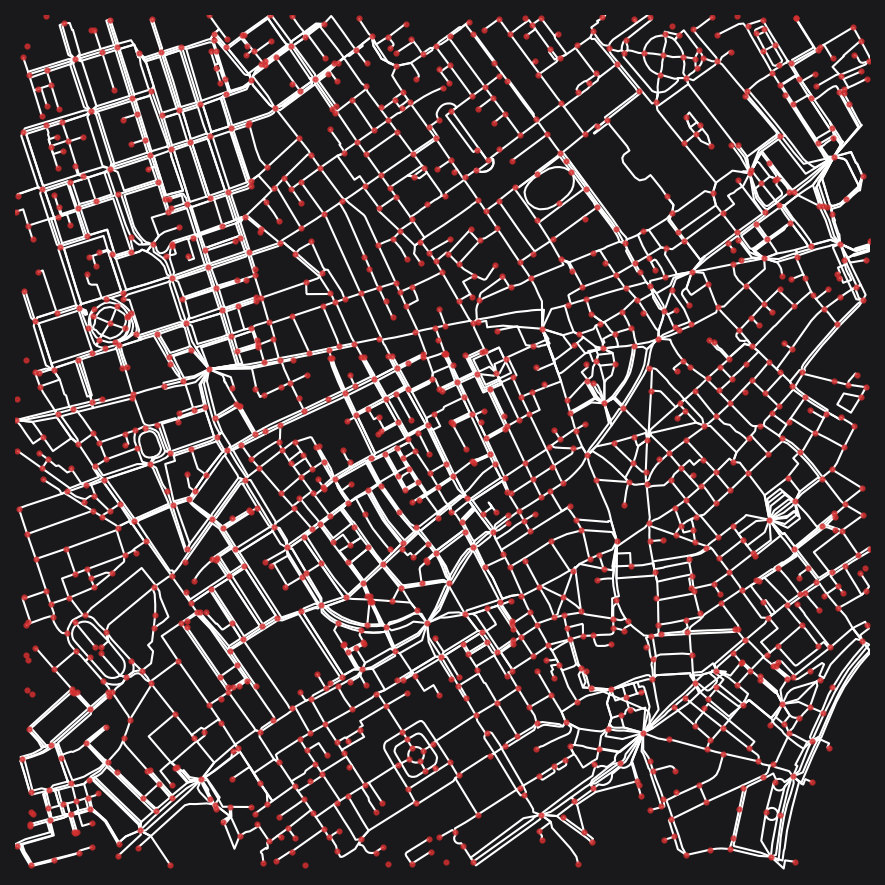

In [3]:
# Workflow 1: Using OSMnx to prepare the graph
# ============================================
# explicit simplification and consolidation via OSMnx
multi_di_graph_utm = ox.project_graph(multi_di_graph_raw)
multi_di_graph_simpl = ox.simplify_graph(multi_di_graph_utm)
multi_di_graph_cons = ox.consolidate_intersections(
    multi_di_graph_simpl, tolerance=10, dead_ends=True
)
# let's use the same plotting function for both scenarios to aid visual comparisons
multi_graph_cons = io.nx_from_osm_nx(multi_di_graph_cons, tolerance=50)
simple_plot(multi_graph_cons)

## Workflow 2

Another option is to simply download the OSM graph directly from within `cityseer`. The following uses a default OSM query, however, the [OSM Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL) can be used to roll-your-own. See documentation for more information.


INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████| 14807/14807 [00:00<00:00, 439324.16it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|██████████| 16107/16107 [00:00<00:00, 740244.29it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 16107/16107 [00:00<00:00, 57870.53it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 14807/14807 [00:02<00:00, 6451.58it/s]
INFO:cityseer.tools.util:Creating edges STR tree.
100%|██████████| 7848/7848 [00:02<00:00, 3795.43it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 5079/5079 [00:00<00:00, 33004.53it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 5677/5677 [00:00<00:00, 283931.50it/s]
INFO:cityseer.tools.util:Creating edges STR tree.
100%|██████████| 4592

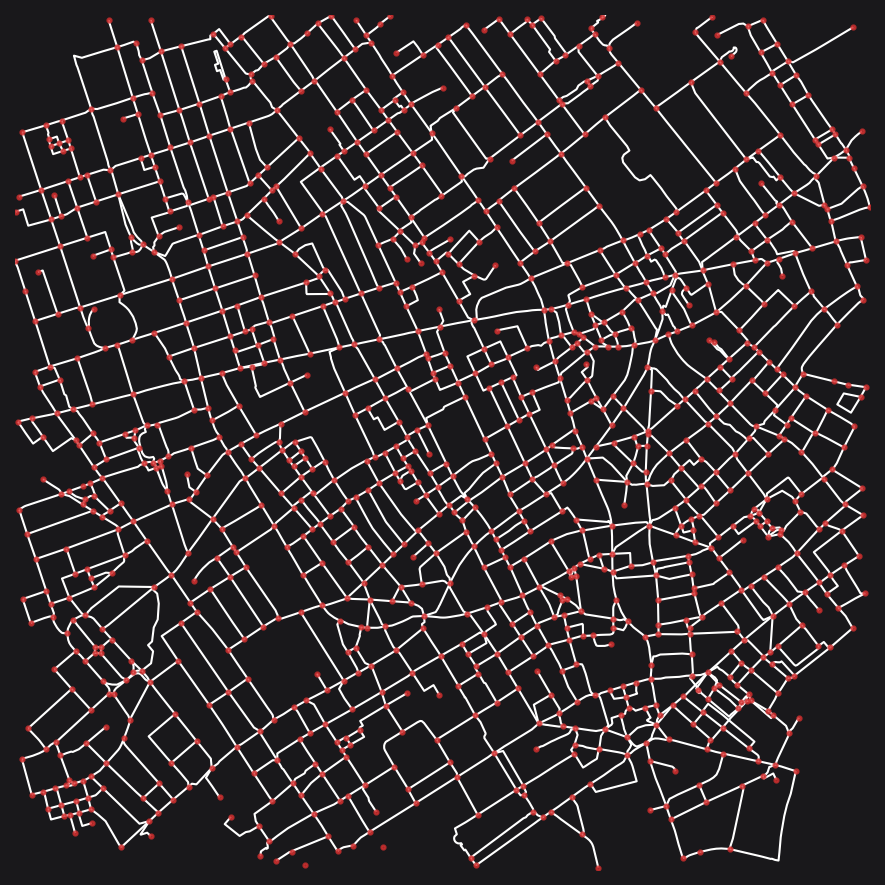

In [4]:
# WORKFLOW 2: Using cityseer to download and automatically simplify the graph
# ===========================================================================
poly_wgs, _ = io.buffered_point_poly(lng, lat, buffer_dist)
G_utm = io.osm_graph_from_poly(poly_wgs, simplify=True)
simple_plot(G_utm)